## List of inputs:



* nside
* lmax (controls the number of wigner modes, maybe set as default to 2)


* location. HERA should be default, so maybe not?
* obstime
* ell_mode (for ordering, always dipole?)
* m_mode (for ordering, always dipole?)
* real
* imag
* real_0  (better naming?)
* spin_weight? (it should always be zero though, so maybe not)

In [1]:
import numpy as np
import scipy as sp

# Plotting
#import matplotlib.pyplot as plt
#import cmocean
#import cmocean.cm as cmo
import pylab as plt

# Mapping
import healpy as hp

# Wigner D matrices
import spherical, quaternionic

# Pandas, dataframe
import pandas as pd

# All things astropy
from astropy import units
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.coordinates.builtin_frames import AltAz, ICRS
from astropy.time import Time

In [2]:
def get_zenith_coord(nside, location, obstime):
    """
    Uses location and obstime to calculate the RA/Dec coordinates and pixel index of zenith above the given location.
    
    ** Inputs:
    
    location: given as an astropy `EarthLocation` object
    obstime: given as an astropy `Time` object
    nside: Resolution
    
    ** Outputs:
    
    ra_zenith: Right ascention of zenith at given location and obstime in radian
    dec_zenith: Declination of zenith at given location and obstime in radian
    lst: Local sidereal time corresponding to the given opstime and longitude in radian
    pix_zenith: The index of the pixel at zenith given the resolution (nside)
    
    """
    
    # Define AltAz frame at time 0
    frame_altaz0 = AltAz(obstime=obstime, location=location)
    
    # # Define a coordinate that is at the zenith at time 0
    zenith_at_loc_altaz = SkyCoord(alt=90.*units.degree, az=0.*units.degree, frame=frame_altaz0)
    zenith_at_loc_radec = zenith_at_loc_altaz.copy().transform_to('icrs')

    # Get zenith coordinates
    ra_zenith = zenith_at_loc_radec.ra
    dec_zenith = zenith_at_loc_radec.dec
    
    # get local sidereal time of obstime0 at this longitude, in radians
    lst = obstime.sidereal_time(kind='mean', longitude=location.lon)
    
    # Get the zenith pixel number
    pix_zenith = hp.ang2pix(nside, ra_zenith.deg, dec_zenith.deg, lonlat=True)
    
    return ra_zenith.rad, dec_zenith.rad, lst.rad, pix_zenith

In [3]:
def get_index_dataframe(lmax):#, ell=0, m=0):
    '''
    Function to get the list of indices (i, ell, m) for ALL the modes in the `spherical` code
    
    ** Returns
    
    mode_indices: pandas dataframe with indices ordered as (i, ell, m) where i is the 'global' index of the alm-modes.
    
    '''
    # Number of modes 
    nmodes_wigner = lmax*(lmax+2)+1                                  # all modes
    nmodes_healpy = lmax * (2 * lmax + 1 - lmax) // 2 + lmax + 1     # only m>=0 modes

    # Create empty Modes object to get indices
    modes = spherical.Modes(np.zeros(shape=nmodes_wigner, dtype=np.complex128), spin_weight=0)

    #Get ell, m and global index i according to the `spherical` ordering
    indices = np.empty(shape=(nmodes_wigner,2))
    for ell_mode in range(0,lmax+1):
        for m_mode in range(-ell_mode,ell_mode+1):
            i = modes.index(ell=ell_mode,m=m_mode)
            indices[i] = [ell_mode, m_mode]

    indices_df =  pd.DataFrame(indices)
    indices_df.columns = ['ell', 'm']
    
    # List of wigner indices
    mode_indices = indices_df
   
    return mode_indices

In [4]:
def ordering(lmax, ell=0, m=0):
    '''
    Function to ensure the correct ordering of alm-modes when switching between `HEALpy` and `spherical`.
    Finds the indices to convert between the ordering of 'HEALpy' and 'spherical' using ALL modes
    
    ** Returns
    
    wigner2healpy: indices in a list to go from `spherical` ordering to `HEALpy`
    healpy2wigner: indices in a list to go from `HEALpy` ordering to `spherical`
    neg_modes_index: Index of where to cut off negative modes to get to `HEALpy`s alm-convention. Necessary for plotting.
    index_ell_mode: Gets `spherical` indices of the modes matching the input `ell` value Default ell=0 mode.
    index_m_mode: Gets `spherical` indices of the modes matching the input `m` value. Default m=0 mode.
    
    '''
    # Number of modes 
    nmodes_wigner = lmax*(lmax+2)+1                                  # all modes
    nmodes_healpy = lmax * (2 * lmax + 1 - lmax) // 2 + lmax + 1     # only m>=0 modes

    
    # List of wigner indices
    mode_indices = get_index_dataframe(lmax)#, ell, m)

    # Sort indices: spherical (wigner) -->  HEALpy
    df1 = mode_indices.sort_values(['m', 'ell'])
    wigner2healpy = df1.index.to_list()
    
    # Sort indices: HEALpy --> spherical (wigner)
    reset = df1.reset_index()  # resets to HEALpy as standard
    df2 = reset.sort_values(['ell', 'm'])
    healpy2wigner = df2.index.to_list()

    # Get ell, m indicies (ONLY FOR WIGNER)
    index_ell_mode = df1.loc[df1.ell == ell].index.tolist()
    index_m_mode = df1.loc[df1.m == m].index.tolist()
    
    # Get cutoff index for removing negative modes
    neg_modes_index = nmodes_wigner-nmodes_healpy
    
    return wigner2healpy, healpy2wigner, neg_modes_index, index_ell_mode, index_m_mode

In [5]:
def create_modes(real, imag, real_0, lmax, ell_mode=1):
    """
    Sets up both 'modes' and 'alms' following the conventions used by `spherical` and `HEALpy` respectively.

    Creates alm-modes according to the rule needed to obtain a real field (for all ell):
    (a_l,+m).real = -(a_l,-m).real
    (a_l,+m).imag = +(a_l,-m).imag


    ** Input:
    
    lmax: Max ell-value, determines number of modes via `lmax*(lmax+2)+1`
    ell_mode: determines the order of the multipole. Default ell_mode=1 for the dipole
    
    real: value of the real part of the `ell != 0` modes. The sign follows the `ell > 0` modes.
    imag: value of the imaginary part of the `ell != 0` modes. Positive values moves it to the left
    real_0: numerical value of the `ell = 0` mode
    
     
    ** Output:
    
    modes: wigner modes, use these for rotations
    alms: healpy alms, use these for plotting via healpy
    
    """
    nmodes_wigner = lmax*(lmax+2)+1
    set_modes = np.zeros(nmodes_wigner, dtype=complex)
    
    # Get ell indices
    _, _, _, index_ells, _ = ordering(lmax, ell=ell_mode)
    middle_index = int((len(index_ells) - 1)/2)

    set_modes[index_ells[0:middle_index]]  = +real + imag
    set_modes[index_ells[middle_index]]    = real_0 
    set_modes[index_ells[middle_index+1:]] = -real + imag
    
    
    #set_alm_values = create_modes(lmax, ell_mode, real, imag, real_0)
    modes = spherical.Modes(set_modes, spin_weight=0)

    wigner2healpy, _, neg_modes_index, _, _ = ordering(lmax, ell=ell_mode)
    alms = modes.ndarray[wigner2healpy][neg_modes_index:]
    
    
    return modes, alms

In [6]:
def modes2map(modes, nside, lmax, ell_mode=1):
    
    wigner2healpy, healpy2wigner, neg_modes_index, index_ells, _ = ordering(lmax, ell=ell_mode)
    
    # Order the modes to fit with HEALpy
    wigner_ordered = modes[wigner2healpy][neg_modes_index:]
    ordered_map = hp.alm2map(wigner_ordered, nside)    # for plotting purposes 

    return ordered_map

In [7]:
def spherical_rotate_modes(modes, lmax, theta, phi, psi=0):
    """ Performs the actual ROTATIONS of the modes directly using the `spherical` code without calculating the wigner 𝔇-matrix.
    
    Parameters
    ----------

    modes: `spherical` modes object
        Wigner/`spherical` modes to rotate. Do not give it HEALpy alms
    lmax: int 
        Sets the number of modes (used for creating the `Wigner` object)

    phi: (radian) Corresponds to RA. Sign is automatically changed to fit with `spherical`
    theta: (radian) Corresponds to declination.
    psi: (radian) Is per default set to zero, but can be set if wanted.
    
    
    Returns
    -------
    
    modes_rot : `spherical` modes object
        The new/rotated modes given the input angles
    
    Notes
    -----
    This assumes rotation Euler angles for `spherical` given by:
    
      * zyz-convention
      * Order of rotations: phi --> theta --> psi
      * phi and theta are swapped compared to astropy 
      * phi has the opposite sign compared to astropy

      ==> phi is equivalent to negative longitude/ RA
      ==> theta is latitude / dec>
      ==> psi should be set to zero
      
    """
    # FixMe: Make an assertion that the angles are actaully given in radian

    # Calculate rotation of a_lms
    wigner = spherical.Wigner(ell_max=lmax)
    rotate_to_coord = quaternionic.array.from_euler_angles(psi, theta, -phi)
    rotated_modes = wigner.rotate(modes, rotate_to_coord)
        
    return rotated_modes

In [8]:
def spherical_set_coords(modes, lmax, dec, ra, lst):
    """
    Rotation Euler angles for `spherical`:
    
      * zyz-convention
      * Order of rotations: phi --> theta --> psi
      * phi and theta are swapped compared to astropy 
      * phi has the opposite sign compared to astropy

      ==> phi is equivalent to negative longitude/ hour angle: HA = LST - RA
      ==> theta is latitude / dec
      ==> psi should be set to zero
      
    phi: (radian) Corresponds to HA. Sign is automatically changed to fit with `spherical`
    theta: (radian) Corresponds to declination.
    psi: (radian) Is per default set to zero.

    ** Input:

    modes: Wigner/`spherical` modes to rotate. Do not give it HEALpy alms
    lmax: Sets the number of modes (used for creating the `Wigner` object)
    dec: The declination of the source in RADIANS
    ra: The Right ascension of the source in RADIANS
    lst: The local sidereal time of the source in RADIANS
    
    ** Output:
    
    rotated_modes: The modes rotated into the correct coordinates in a HA/Dec coordinate system
      
    """
    # FixMe: Make an assertion that the angles are actaully given in radian
    
    # Change into an HA/Dec system
    ha = lst - ra
    
    # Set euler angles
    phi = -ha
    theta = dec
    psi = 0

    # Calculate rotation of a_lms
    wigner = spherical.Wigner(ell_max=lmax)
    rotate_to_coord = quaternionic.array.from_euler_angles(psi, theta, phi)
    rotated_modes = wigner.rotate(modes, rotate_to_coord)
    
    return rotated_modes

In [9]:
def WignerDsize(ell_min, mp_max, ell_max=-1): # function taken from the `spherical` utilities
    if ell_max < 0:
        ell_max = mp_max
    if mp_max >= ell_max:
        return (
            ell_max * (ell_max * (4 * ell_max + 12) + 11)
            + ell_min * (1 - 4 * ell_min**2)
            + 3
        ) // 3
    if mp_max > ell_min:
        return (
            3 * ell_max * (ell_max + 2)
            + ell_min * (1 - 4 * ell_min**2)
            + mp_max * (
                3 * ell_max * (2 * ell_max + 4)
                + mp_max * (-2 * mp_max - 3) + 5
            )
            + 3
        ) // 3
    else:
        return (ell_max * (ell_max + 2) - ell_min**2) * (1 + 2 * mp_max) + 2 * mp_max + 1

In [10]:
def WignerDrange(ell_min, mp_max, ell_max=-1): # function taken from the `spherical` utilities
    """Create an array of (ℓ, m', m) indices as in 𝔇 array"""
    if ell_max < 0:
        ell_max = mp_max
    r = np.zeros((WignerDsize(ell_min, mp_max, ell_max), 3), dtype=np.int64)
    i = 0
    for ell in range(ell_min, ell_max+1):
        for mp in range(-min(ell, mp_max), min(ell, mp_max)+1):
            for m in range(-ell, ell+1):
                r[i, 0] = ell
                r[i, 1] = mp
                r[i, 2] = m
                i += 1
    return r


In [11]:
def WignerDindex(ell, mp, m, ell_min=0, mp_max=-1): # from the spherical utilities
    """Compute index into Wigner 𝔇 matrix
    Parameters
    ----------
    ell : int
        Integer satisfying ell_min <= ell <= ell_max
    mp : int
        Integer satisfying -min(ell_max, mp_max) <= mp <= min(ell_max, mp_max)
    m : int
        Integer satisfying -ell <= m <= ell
    ell_min : int, optional
        Integer satisfying 0 <= ell_min <= ell_max.  Defaults to 0.
    mp_max : int, optional
        Integer satisfying 0 <= mp_max.  Defaults to ell.
    Returns
    -------
    i : int
        Index into Wigner 𝔇 matrix arranged as described below
    See Also
    --------
    WignerDsize : Total size of the 𝔇 matrix
    WignerDrange : Array of (ℓ, m', m) indices corresponding to the 𝔇 matrix
    Notes
    -----
    This assumes that the Wigner 𝔇 matrix is arranged as
        [
            𝔇(ℓ, mp, m)
            for ℓ in range(ell_min, ell_max+1)
            for mp in range(-min(ℓ, mp_max), min(ℓ, mp_max)+1)
            for m in range(-ℓ, ℓ+1)
        ]
    """
    if mp_max < 0:
        mp_max = ell
    i = (mp + min(mp_max, ell)) * (2 * ell + 1) + m + ell
    if ell > ell_min:
        i += WignerDsize(ell_min, mp_max, ell-1)
    return i

In [12]:
def D_matrix_1D(modes, lmax, ra, dec, ha):# ha_radian=False, ha_manual=False, to_ra=False):
    """
    Rotation Euler angles for `spherical`:
    
      * zyz-convention
      * Order of rotations: phi --> theta --> psi
      * phi and theta are swapped compared to astropy 
      * phi has the opposite sign compared to astropy
     
    phi: (radian) Corresponds to change in HA. Sign is automatically changed to fit with `spherical`
    theta: (radian) Corresponds to declination.
    psi: (radian) Is per default set to zero.
      

    ** Input:

    modes: Wigner/`spherical` modes to rotate. Do not give it HEALpy alms
    lmax: Sets the number of modes (used for creating the `Wigner` object)
    dec: The declination of the source in RADIANS
    ha: The hour angle of the source. Assumes that it's given as a fraction of a sidereal day 
        * If ha_manual=True, input hour angle manually in HH:MM:SS.SS format. 
        * If ha_radian=True give the hour angle in radian
        * If to_ra=True give the right ascension and lst instead in an array ha=[ra, lst]

    """
    # FixMe: bit messy, fix assertions
     
    
#     if np.size(ha)==1:
#         if ha_radian==False and ha_manual==False and ra==False:
#             hour_angle = np.radians(ha*360)
        
#         elif ha_manual==True:
#             #inset assertion that the hour angle is given in HH:MM:SS.SS format
        
#             hour, minute, second = ha.split(':')
#             time_sec = float(hour)*3600 + float(minute)*60 + float(second)
#             hour_angle = np.radians(time_sec/(24*60*60)*360)

#         elif ha_radian==True:
#             hour_angle = ha
            
#     elif np.size(ha)==2:
#         assert(to_ra==True)
#         # maybe do it as an 'or' and have an assertion of the other element
#         ra, lst = ha
#         hour_angle = lst - ra
        
    hour_angle = np.radians(ha*360)
              
    # Set euler angles with 'spherical' sign convention
#     phi = -hour_angle   ### Wrong, phi needs to be the orignal ra+ha, still doesn't work
    phi = ra_zenith+hour_angle
    theta = dec
    psi = 0


    # Calculate rotation of a_lms
    wigner = spherical.Wigner(ell_max=lmax)
    rotate_to_coord = quaternionic.array.from_euler_angles(psi, theta, -phi)
    wigner_D_matrix_1D = wigner.D(rotate_to_coord)
        
    return wigner_D_matrix_1D

In [13]:
def D_matrix_per_ell_2D(D_matrix_as_1D, ell, lmax):
    
    assert ell <= lmax, "ell has to be smaller or equal to lmax (ell <= lmax)"
    
    m_range = np.arange(-ell,ell+1)
    
    # Make empty 2D D-matrix with correct shape given by m x mp
    D_matrix_as_2D = np.zeros(shape=(np.size(m_range),np.size(m_range)), dtype=complex)
        
    m_count = 0
    for m in m_range:
        
        mp_count=0

        for mp in np.arange(-ell, ell+1):
            # Get the correct value from the 1D D-matrix
            index = WignerDindex(ell, mp, m, ell_min=0, mp_max=lmax)
            value = D_matrix_as_1D[index]
            
            # Save it into the correct index in the 2D D-matrix
            D_matrix_as_2D[m_count, mp_count] = value
    
            mp_count += 1

        m_count += 1
    
    return D_matrix_as_2D

In [14]:
def combined_D_matrix(D_matrix_1D, lmax):
    '''
    Calculate the separate 2D D-matrices per ell-value, combined into one block diagonal matrix
    '''
   
    combined_D = np.zeros(shape=0, dtype=complex)

    for ell in np.arange(0,lmax+1):
        ell_value = ell
        
        D_matrix_2D = D_matrix_per_ell_2D(D_matrix_1D, ell_value, lmax)
        
        if ell_value == 0:
            combined_D = D_matrix_2D
        else:
            combined_D = sp.linalg.block_diag(combined_D, D_matrix_2D)
        
    return combined_D

# np.shape(combined_D_matrix(D_matrix, lmax))

In [15]:
def rotate_modes_D_matrix(D_matrix_1D, modes, lmax):
    '''
    Calculate the separate D-matrices per ell-value, apply the rotations, combine into one modes-array
    '''
    # get pandas dataframe with indices ordered as (i, ell, m)
    my_wigner_df = get_index_dataframe(lmax)
    all_ell_list = my_wigner_df.copy().to_numpy()[:,0]
    
    
    D_rot_modes = np.zeros(shape=0, dtype=complex)

    for ell in np.arange(0,lmax+1):
        ell_value = ell
        indices = np.where(all_ell_list == ell_value)
        modes_per_ell = np.dot(D_matrix_per_ell_2D(D_matrix_1D, ell_value, lmax), modes[indices])
        D_rot_modes = np.concatenate((D_rot_modes, modes_per_ell), axis=0)
        
    return D_rot_modes

In [16]:
# Resolution
nside=1024

# HERA location
location = EarthLocation.from_geodetic(lat=-30.7215,
                                       lon=21.4283,
                                       height=1073.)
# Observation time 0
obstime0 = Time('2022-06-27T01:02:30.11', format='isot', scale='utc') 

# Calculate zenith coordinates
ra_zenith, dec_zenith, lst, pix_zenith = get_zenith_coord(nside=nside, location=location, obstime=obstime0)

In [17]:
# Choose values for alms
real=1
imag=0j # positive moves it to the left
real_0=0

lmax = 2
ell_mode = 1



In [18]:
# Calculate modes and alms
modes, alms = create_modes(real, imag, real_0, lmax, ell_mode)

# Use Wigner rotations directly to 'rotate' into the zenith above HERA
modes_init = spherical_rotate_modes(modes=modes,
                                   lmax=lmax,
                                   theta=dec_zenith,
                                   phi=ra_zenith)

# # This essentially does the same as "spherical_rotate_modes" but in HA/Dec
# source_modes = spherical_set_coords(modes=modes,
#                                     lmax=lmax,
#                                     dec=dec_zenith,
#                                     ra=ra_zenith,
#                                     lst=lst)

In [19]:
# Second observation time 
obstime1 = Time('2022-06-27T15:02:30.11', format='isot', scale='utc') 

# Time of rotation given as fraction of a sidereal day
rotation_time = (obstime1-obstime0).value

# This is where the D-matrix is first calculated
# D_matrix = D_matrix_1D(modes=modes, lmax=lmax, theta=dec_zenith, phi=ra_zenith)
D_matrix = D_matrix_1D(modes=modes_init, lmax=lmax, ra=ra_zenith, dec=dec_zenith, ha=rotation_time)



print(np.shape(D_matrix))
#rotate_to_coord = quaternionic.array.from_euler_angles(0, dec_zenith, -ra_zenith)
rotation_time
print(ra_zenith+np.radians(rotation_time*360))
ra_zenith

(35,)
9.107775435453483


5.442584006265391

In [20]:

# D_range = WignerDrange(0, lmax, lmax)
# print(np.shape(D_range))
# print(D_range)
# print(D_range[:,0])
# print(WignerDsize(0, lmax, lmax))

In [21]:


# WignerDindex(ell=D_range[:,0], mp=D_range[:,1], m=D_range[:,2], ell_min=0, mp_max=lmax)

#WignerDindex(ell=D_range[3,0], mp=D_range[3,1], m=D_range[3,2], ell_min=0, mp_max=lmax)

In [22]:
# #test_matrix = np.arange(0,35)+1
# test_matrix = D_range[:,0]


# for ell_value in np.arange(0,lmax+1):
    
#     m_range = np.arange(-ell_value,ell_value+1)
#     ell_matrix = np.zeros(shape=(np.size(m_range),np.size(m_range)))
# #     print(ell_matrix)
        
#     m_count = 0
#     for m_value in m_range:
        
#         mp_count=0

#         for mp_value in np.arange(-ell_value, ell_value+1):
            
#             index = WignerDindex(ell=ell_value, mp=mp_value, m=m_value, ell_min=0, mp_max=lmax)
#             value = test_matrix[index]
            
#             ell_matrix[m_count,mp_count] = value
    
#             mp_count += 1

#         m_count += 1
    
#     # so far so good! Now I just need to save out the three matrices. Maybe via sparse matrices?
#     print(ell_matrix)
# # D_range[]


In [23]:
print(D_matrix_per_ell_2D(D_matrix, 1, lmax))

[[-0.88314596+2.89730201e-01j -0.3440802 +1.12881029e-01j
  -0.06702809+2.19896418e-02j]
 [-0.36212333-1.00509416e-17j  0.85891407+0.00000000e+00j
   0.36212333-1.00509416e-17j]
 [-0.06702809-2.19896418e-02j  0.3440802 +1.12881029e-01j
  -0.88314596-2.89730201e-01j]]


In [24]:
# get pandas dataframe with indices ordered as (i, ell, m)
my_wigner_df = get_index_dataframe(lmax)#, ell=ell_mode)
all_ell_list = my_wigner_df.copy().to_numpy()[:,0]

print(all_ell_list)



ell_value = 1 
indices = np.where(all_ell_list == 1)
print(f'\n Rotated modes for ={ell_value} is: \n\n {np.dot(D_matrix_per_ell_2D(D_matrix, ell_value, lmax), modes[indices])}')

[0. 1. 1. 1. 2. 2. 2. 2. 2.]

 Rotated modes for =1 is: 

 [-0.81611787+0.26774056j -0.72424667+0.j          0.81611787+0.26774056j]


In [26]:
# Create and check that the total calcualted D-matrix also results in the same rotated 
# modes as when rotated using the `spherical` code
new_modes = np.zeros(shape=0, dtype=complex)

for ell in np.arange(0,lmax+1):
    ell_value = ell
    indices = np.where(all_ell_list == ell_value)
    modes_per_ell = np.dot(D_matrix_per_ell_2D(D_matrix, ell_value, lmax), modes[indices])
#     print(np.dot(D_matrix_per_ell_2D(D_matrix, ell_value, lmax), modes[indices]))
    new_modes = np.concatenate((new_modes, modes_per_ell), axis=0)

print(new_modes)
#modes_rot == new_modes

[ 0.        +0.j         -0.81611787+0.26774056j -0.72424667+0.j
  0.81611787+0.26774056j  0.        +0.j          0.        +0.j
  0.        +0.j          0.        +0.j          0.        +0.j        ]


In [27]:
np.dot(combined_D_matrix(D_matrix, lmax), modes)


array([ 0.        +0.j        , -0.81611787+0.26774056j,
       -0.72424667+0.j        ,  0.81611787+0.26774056j,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ,
        0.        +0.j        ])

In [28]:
#combined_D_matrix(D_matrix, lmax)

In [29]:
D_rot_modes = rotate_modes_D_matrix(D_matrix, modes, lmax) 

print(D_rot_modes == np.dot(combined_D_matrix(D_matrix, lmax), modes))
print(D_rot_modes == new_modes)
print(D_rot_modes == modes_rot)

[ True  True  True  True  True  True  True  True  True]
[ True  True  True  True  True  True  True  True  True]


NameError: name 'modes_rot' is not defined

In [30]:
# Order the modes to fit with HEALpy
rot_wigner_ordered_map = modes2map(modes=D_rot_modes, nside=nside, lmax=lmax, ell_mode=ell_mode)
# rot_wigner_ordered_map = modes2map(modes=modes_rot, nside=nside, lmax=lmax, ell_mode=ell_mode)
orig_map = modes2map(modes=modes_rot, nside=nside, lmax=lmax, ell_mode=ell_mode)

NameError: name 'modes_rot' is not defined

In [31]:
def poster_map_plot(skymap):
    # Find dipole peak
    mmax = skymap.max()              # max value
    imax = np.where(skymap == mmax) 
    max_vec = hp.pix2vec(nside, ipix=imax)
    max_mark = hp.query_disc(nside, vec=max_vec, radius=0.03)
    print(f'Check: Is the dipole pointing to zenith?\t {imax==pix_zenith}')  #### FixMe: Turn this into an assertion

    rot_dipole_with_peak = skymap.copy() # for plotting purposes only
    rot_dipole_with_peak[max_mark]=-mmax


    # PLOTTING SECTION
    # hp.cartview(dipole_with_peak)
    #hp.mollview(rot_dipole_with_peak)
    #hp.graticule()
    #plt.title("original map, zenith above HERA")
    #plt.show()
    
    ###### Plot section ######
    fig, (ax2) = plt.subplots(ncols=1, figsize=(30,15))
    plt.axes(ax2)

    hp.mollview(rot_dipole_with_peak, title='',
                #title=rf"Wigner rotated map by ({theta}$^\circ$, {phi}$^\circ$)", cmap=cmo.haline)
                cmap='cividis', #cmo.haline,
                hold=True,
                notext=True,
                bgcolor="#d5bc5e00"
               )
    hp.graticule()

    fig.delaxes(fig.axes[1]) # removes colourbar
    fig.savefig(f'{skymap}.png', bbox_inches='tight', transparent=True, dpi=fig.dpi)
    
poster_map_plot(skymap=orig_map)
poster_map_plot(skymap=rot_wigner_ordered_map)

NameError: name 'orig_map' is not defined

# Use the peak of a dipole to check the rotations also match astropy

0.0 180.0 -180.0 180.0


Check: Is the dipole pointing to zenith?	 [[False]]


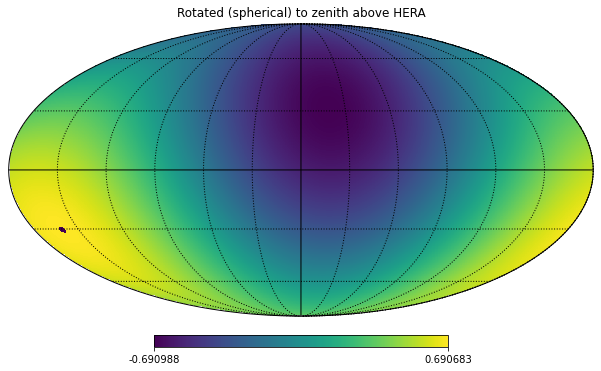

In [32]:


# Find dipole peak
mmax = rot_wigner_ordered_map.max()              # max value
imax = np.where(rot_wigner_ordered_map == mmax) 
max_vec = hp.pix2vec(nside, ipix=imax)
max_mark = hp.query_disc(nside, vec=max_vec, radius=0.03)
print(f'Check: Is the dipole pointing to zenith?\t {imax==pix_zenith}')  #### FixMe: Turn this into an assertion

rot_dipole_with_peak = rot_wigner_ordered_map.copy() # for plotting purposes only
rot_dipole_with_peak[max_mark]=-mmax


# PLOTTING SECTION
# hp.cartview(dipole_with_peak)
hp.mollview(rot_dipole_with_peak)
hp.graticule()
plt.title("Rotated (spherical) to zenith above HERA")
plt.show()


# Rotate the point one full day using D-matrix rotations

In [33]:
# ROTATION EULER ANGLES for `spherical`
"""
  zyz-convention
  phi --> theta --> psi
  phi and theta are swapped compared to astropy 
  phi has the opposite sign

  ==> theta is negative longitude, phi is latitude, psi is zero
"""

full_day_ras = np.linspace(0,2*np.pi,200)

# initialise loop:
peaks = np.zeros(shape=full_day_ras.size, dtype=int)
# max_vecs = np.zeros(shape=(3,full_day_ras.size))
max_dipoles = list()
max_dipoles_plot = list()
rotate_modes = modes_rot.copy()

j = 0

for phi in full_day_ras:
    psi, theta = 0, 0#np.radians(dec_zenith)

    
    # Calculate rotation of a_lms
    rotate_modes = spherical_rotate_modes(modes=rotate_modes, lmax=lmax, theta=theta, phi=phi)

    # Order the modes to fit with HEALpy
    rot_wigner_ordered_map = modes2map(modes=rotate_modes, nside=nside, lmax=lmax, ell_mode=ell_mode)

    # Find dipole peak
    mmax = rot_wigner_ordered_map.max()              # max value
    imax = np.where(rot_wigner_ordered_map == mmax) 
    max_vec = hp.pix2vec(nside, ipix=imax)
    max_dipole_plot = hp.query_disc(nside, vec=max_vec, radius=0.03) # larger radius for visualisation
    max_dipole = hp.query_disc(nside, vec=max_vec, radius=0.001)
    
    peaks[j] = imax[0]
    max_dipoles.append(max_dipole)
    max_dipoles_plot.append(max_dipole_plot)
        
    j+=1

max_dipoles_plot = np.concatenate(max_dipoles_plot).ravel()  
max_dipoles = np.concatenate(max_dipoles).ravel()  # turn it into one long array

NameError: name 'modes_rot' is not defined

In [ ]:
rotation_map = np.zeros(shape=hp.nside2npix(nside))


# rotation_map[max_mark] = -100 
rotation_map[max_dipoles_plot] = 100   # Marking the rotated points
rotation_map[max_mark] = -100          # Re-marking the original point in a different colour


# PLOTTING SECTION
hp.mollview(rotation_map)
hp.graticule()
plt.title(f"Rotation of a full day \nstart obstime = {obstime0}")
plt.show()

In [ ]:
ra_rotated, dec_rotated = hp.pix2ang(nside, ipix=peaks, lonlat=True)
coord_rot_radec = SkyCoord(ra=ra_rotated, dec=dec_rotated, unit="deg", frame='icrs')

In [ ]:
# Is it correct to just use obstime0? 
coord_rot_altaz = coord_rot_radec.transform_to(AltAz(obstime=obstime0, location=location)) 
#el, az = coord_rot_altaz.alt.rad, coord_rot_altaz.az.rad
el, az = coord_rot_altaz.alt.deg, coord_rot_altaz.az.deg

za = np.pi/2-el
# print(za)

In [ ]:
plt.plot(coord_rot_radec.ra,coord_rot_radec.dec,'k.')
plt.xlabel('RA')
plt.ylabel('dec')
plt.title('wigner rotations')

plt.figure()
plt.plot(az,za,'k.')
plt.xlabel('azimuth')
plt.ylabel('zenith angle')
plt.title('wigner rotations')

In [ ]:
plt.plot(az,el,'k.')
plt.xlabel('Az')
plt.ylabel('Alt')

## From test runs of the script:
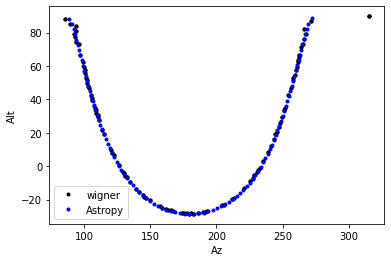
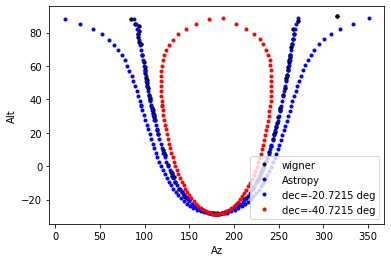
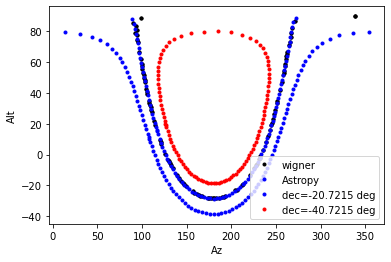

## Check of coordinate system orientation

In [36]:
def orientation_check():
    # Choose values for alms
    real=1
    imag=0j # positive moves it to the left
    real_0=0

    lmax = 2
    ell_mode = 1


    # Calculate modes and alms
    modes, alms = create_modes(real, imag, real_0, lmax, ell_mode)

    thetas_check = np.radians([85, 50, 30, 15, 0])
    phis_check = [2, 1.5, 1, 0.5, 0]
    
    
    # initialise loop:
    max_dipoles = list()
    rotation_map = np.zeros(shape=hp.nside2npix(nside))

    
    # Use Wigner rotations to 'rotate' into the zenith above HERA
    for theta_check in thetas_check:
        #modes_rot = spherical_rotate_modes(modes=modes, lmax=lmax, theta=theta, phi=phi_check)
        
        # This is where the D-matrix is first calculated
        D_matrix = D_matrix_1D(modes=modes, lmax=lmax, theta=theta_check, phi=np.radians(0))

        # This is the actual rotation
        D_rot_modes = rotate_modes_D_matrix(D_matrix, modes, lmax) 
        modes_rot_map = modes2map(modes=D_rot_modes, nside=nside, lmax=lmax, ell_mode=ell_mode)

        # checkpoint
    #         print(modes_rot == D_rot_modes) # True
    
        # Find dipole peak
        mmax = modes_rot_map.max()              
        imax = np.where(modes_rot_map == mmax)[0][0]
        max_vec = hp.pix2vec(nside, ipix=imax)
        max_mark = hp.query_disc(nside, vec=max_vec, radius=0.03)
    
        max_dipoles.append(max_mark)
        rotation_map[np.concatenate(max_dipoles).ravel()] += 15
        
    max_dipoles = list()
    # Use Wigner rotations to 'rotate' into the zenith above HERA
    for phi_check in phis_check:
#         modes_rot = spherical_rotate_modes(modes=modes, lmax=lmax, theta=theta, phi=phi_check)
        
        # This is where the D-matrix is first calculated
        D_matrix = D_matrix_1D(modes=modes, lmax=lmax, theta=np.radians(0), phi=phi_check)

        # This is the actual rotation
        D_rot_modes = rotate_modes_D_matrix(D_matrix, modes, lmax) 
        modes_rot_map = modes2map(modes=D_rot_modes, nside=nside, lmax=lmax, ell_mode=ell_mode)

        # checkpoint
    #         print(modes_rot == D_rot_modes) # True
    
        # Find dipole peak
        mmax = modes_rot_map.max()              
        imax = np.where(modes_rot_map == mmax)[0][0]
        max_vec = hp.pix2vec(nside, ipix=imax)
        max_mark = hp.query_disc(nside, vec=max_vec, radius=0.03)
    
        max_dipoles.append(max_mark)
        rotation_map[np.concatenate(max_dipoles).ravel()] += 15

    hp.mollview(rotation_map)
    hp.graticule()
    plt.title(f"Orientation check")
    plt.show()


orientation_check()

NameError: name 'theta' is not defined

In [ ]:
np.radians((7380/86400)*360)